## **RAG for Insurance Documents**

### **By Sivan Itzhaki**






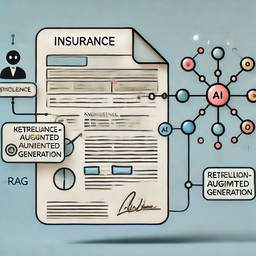

## **RAG-Based Insurance Policy Q&A System**
This notebook presents an AI-powered Q&A system using RAG to extract, analyze, and retrieve accurate answers from insurance policies.

---
### **Challenge**
Insurance documents contain vast information on **terms, coverage, and obligations**. Retrieving relevant details efficiently is difficult, especially with multiple documents.

### **Solution: RAG System**
A **Retrieval-Augmented Generation (RAG) system** was developed to:
- **Retrieve relevant sections** using **FAISS & embeddings**.
- **Generate precise, context-aware answers** using an LLM.

---

## **Methodology**

### **Document Processing & Chunking**
- **Preprocessing**: Removed unnecessary headers/footers, handled Hebrew formatting.
- **Chunking**: Used **RecursiveCharacterTextSplitter** to preserve context.

### **Embedding & LLM Selection**
- **Embeddings**: Compared **OpenAI vs. MiniLM (Hugging Face)** for retrieval accuracy.
- **LLM**: Evaluated **GPT-4o (faster, cost-effective) vs. O1-mini (detailed reasoning, slower)**.

### **Prompt Engineering**
- **Strict reliance on retrieved content** to avoid hallucinations.
- **Source citation enforcement** for transparency.
- **Few-shot learning** to improve response consistency.

---

## **Outcome**
A fully implemented **RAG system** providing **accurate, structured responses** from insurance policies.

---

## **Future Improvements**
- Improve **document processing**.  
- Refine **chunking structure**.  
- Test **alternative embeddings & LLMs**.  
- Optimize **prompt engineering** with examples.  
- Monitor **LLM response quality**.  
- Balance **cost vs. performance**.  


- Implemented a **UI interface** allowing users to ask questions and receive answers.  

**Example image of the UI:**  


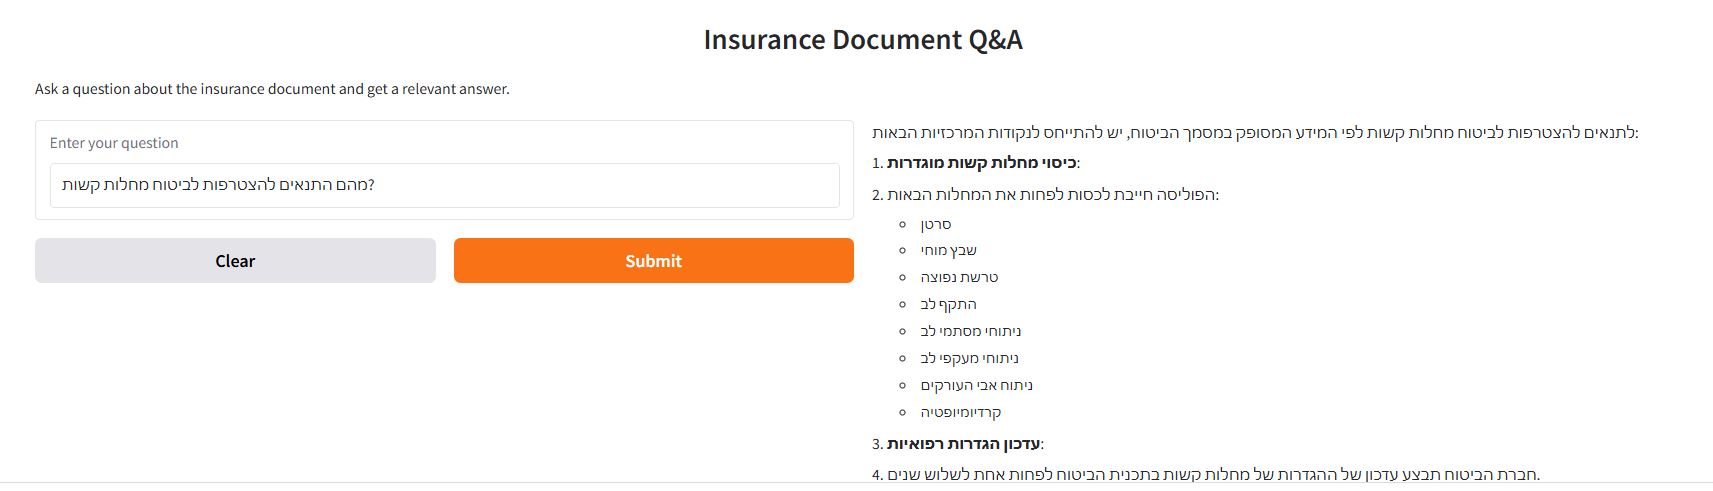

Now, let's dive into the details.

###  Installing Required Libraries

In [ ]:
!pip install langchain_community
!pip install pypdf
!pip install transformers torch sentence-transformers
!pip install tf-keras
!pip install --upgrade transformers==4.38.2
!pip install sentence-transformers
!pip install -U langchain-huggingface
!pip install faiss-cpu
!pip install openai
!pip install PyPDF2
!pip install tiktoken
!pip install gradio

### Imports

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from langchain_huggingface import HuggingFaceEmbeddings
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import FAISS
import os
from langchain.chat_models import ChatOpenAI
from IPython.display import display, Markdown
from PyPDF2 import PdfReader
import re
from langchain_core.prompts  import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
import pandas as pd
from langchain.embeddings import OpenAIEmbeddings
import tiktoken
from markdown import markdown
import gradio as gr

###  Configuring API Key


In [ ]:
api_key = "my_API"

os.environ["OPENAI_API_KEY"] =api_key

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
pdf_path = "insurance.pdf"
print(os.path.exists(pdf_path))


True


# Loading PDF Document  

In [ ]:
pdf_path = "/content/drive/My Drive/Direct_Insurance/LLM_and_RAG/insurance.pdf"

loader = PyPDFLoader(pdf_path)
pages = loader.load()

In [ ]:
print(pages[0].page_content)

מדינת ישראל 
משרד האוצר- אגף שוק ההון, ביטוח וחיסכון 
 
 
רח' קפלן 1, ירושלים 61019    ת.ד1100                טל  00-1117111            פקס00-1961160 
אוצר ברשת- http://www.mof.gov.il 
חלק 1 של שער9 - הוראות לתכניות ופוליסות ביטוח בריאות  
חובות חברת ביטוח טרם השקת תכנית ביטוח בריאות והוראות לתכנית ביטוח 
בריאות ולפוליסת ביטוח בריאות  
 
1. הנהגת תכנית ביטוח בריאות או שינוי בתכנית ביטוח בריאות 
סימן א': נספח אקטוארי בביטוחי בריאות1 
א חברת ביטוח המגישה תוכנית ביטוח בריאות תצרף נספח אקטוארי בשני עותקים בהתאם להוראות שלהלן: 
(1) נספח אקטוארי לתוכנית בריאות חדשה יכלול את הפרטים הבאים 
(א) תיאור של הכיסויים בתוכנית הביטוח, תגמולי הביטוח, תנאי החידוש, אופן המכירה (פוליסה 
בסיסית או נספח), גילאי הצטרפות וגילאי סיום, פוליסת פרט או קבוצתית. 
(ב) מדד הבסיס של כל הנתונים המופיעים בנספח האקטוארי. 
(ג) רשימת פרמיות הסיכון YRT ודמי הביטוח ברוטו לכל גילומין לפי תקופת הביטוח ותקופת ההמתנה. 
יש לציין האם התעריפים הנם חודשיים או שנתיים, קבועים או משתנים לפי גיל, האם הם ליחידת 
ביטוח ומהו השווי של כל יח

In [ ]:
pages[0].metadata

{'producer': 'Microsoft® Word 2010',
 'creator': 'Microsoft® Word 2010',
 'creationdate': '2014-01-29T17:00:11+02:00',
 'title': 'קודקס ביטוח בריאות',
 'author': 'שירה לומר',
 'subject': 'מגי – תירגעי, זה רק לנוחותנו. נפרסם ללא עמוד הפתיחה.',
 'moddate': '2014-01-29T17:00:11+02:00',
 'source': '/content/drive/My Drive/Direct_Insurance/LLM_and_RAG/insurance.pdf',
 'total_pages': 81,
 'page': 0,
 'page_label': '1'}

### Cleaning
Initial review showed that each page contains a recurring header and footer at the beginning of the content. Since they do not provide valuable information, they will be removed.

Additionally, any concatenation of words and numbers will be corrected.


In [ ]:
async def clean_pdf_pages(loader, header_end_marker="http://www.mof.gov.il"):

    cleaned_pages = []

    async for page in loader.alazy_load():
        text = page.page_content
        header_end_index = text.find(header_end_marker)
        if header_end_index != -1:
            text = text[header_end_index + len(header_end_marker):].strip()

        text = re.sub(r"(\d)([א-ת])", r"\1 \2", text)
        text = re.sub(r"([א-ת])(\d)", r"\1 \2", text)

        cleaned_pages.append(Document(page_content=text, metadata=page.metadata))

    return cleaned_pages


In [ ]:
cleaned_pages = await clean_pdf_pages(loader)
full_text = "\n".join(doc.page_content for doc in cleaned_pages)

In [ ]:
print(cleaned_pages[0].page_content)

חלק 1 של שער 9 - הוראות לתכניות ופוליסות ביטוח בריאות  
חובות חברת ביטוח טרם השקת תכנית ביטוח בריאות והוראות לתכנית ביטוח 
בריאות ולפוליסת ביטוח בריאות  
 
1. הנהגת תכנית ביטוח בריאות או שינוי בתכנית ביטוח בריאות 
סימן א': נספח אקטוארי בביטוחי בריאות 1 
א חברת ביטוח המגישה תוכנית ביטוח בריאות תצרף נספח אקטוארי בשני עותקים בהתאם להוראות שלהלן: 
(1) נספח אקטוארי לתוכנית בריאות חדשה יכלול את הפרטים הבאים 
(א) תיאור של הכיסויים בתוכנית הביטוח, תגמולי הביטוח, תנאי החידוש, אופן המכירה (פוליסה 
בסיסית או נספח), גילאי הצטרפות וגילאי סיום, פוליסת פרט או קבוצתית. 
(ב) מדד הבסיס של כל הנתונים המופיעים בנספח האקטוארי. 
(ג) רשימת פרמיות הסיכון YRT ודמי הביטוח ברוטו לכל גילומין לפי תקופת הביטוח ותקופת ההמתנה. 
יש לציין האם התעריפים הנם חודשיים או שנתיים, קבועים או משתנים לפי גיל, האם הם ליחידת 
ביטוח ומהו השווי של כל יחידת ביטוח. 
(ד) הביסוס הסטטיסטי בדבר אופן קביעת פרמיית הסיכון לרבות: 
(1) אפיון האוכלוסייה שעליה התבסס הניתוחותקופת הניסיון; 
(2) השכיחויות, העלויות ומקורותיהן (ספרות, ניסיון של חברת 

###  Token Count in the Document
I check the document’s token count to see if it fits within the 128K context window of GPT models. If it exceeds the limit, I’ll use RAG to retrieve relevant sections instead of passing the full document.

In [ ]:
def count_tokens_from_pages(pages, model_name="gpt-4-turbo"):
    encoding = tiktoken.encoding_for_model(model_name)
    full_text = "\n".join([page.page_content for page in pages])
    num_tokens = len(encoding.encode(full_text))
    return num_tokens


num_tokens = count_tokens_from_pages(cleaned_pages)
print(f"Number of tokens: {num_tokens}")


Number of tokens: 122413


The document has 122,413 tokens, close to the 128K limit of GPT models, leaving little room for queries and responses. Using RAG ensures efficient retrieval and processing.

## Chunking

In this step I am creating the chunks of data, for this step I am using Recursive Character Splitter which break large Documents into smaller chunks. This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won’t fit in a model’s finite context window.

chunk overlap is helpul to handle the data loss while chunking.

length_function measures chunk size based on word count instead of character count.

Separators ensures structured splitting by prioritizing paragraphs, lines, and spaces before raw splitting.

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    length_function=lambda text: len(text.split()),
   separators=["\n\n", "\n", " "]
)


In [ ]:
chunks = text_splitter.split_text(text = full_text)

In [ ]:
display(Markdown(chunks[0]))

חלק 1 של שער 9 - הוראות לתכניות ופוליסות ביטוח בריאות  
חובות חברת ביטוח טרם השקת תכנית ביטוח בריאות והוראות לתכנית ביטוח 
בריאות ולפוליסת ביטוח בריאות  
 
1. הנהגת תכנית ביטוח בריאות או שינוי בתכנית ביטוח בריאות 
סימן א': נספח אקטוארי בביטוחי בריאות 1 
א חברת ביטוח המגישה תוכנית ביטוח בריאות תצרף נספח אקטוארי בשני עותקים בהתאם להוראות שלהלן: 
(1) נספח אקטוארי לתוכנית בריאות חדשה יכלול את הפרטים הבאים 
(א) תיאור של הכיסויים בתוכנית הביטוח, תגמולי הביטוח, תנאי החידוש, אופן המכירה (פוליסה 
בסיסית או נספח), גילאי הצטרפות וגילאי סיום, פוליסת פרט או קבוצתית. 
(ב) מדד הבסיס של כל הנתונים המופיעים בנספח האקטוארי. 
(ג) רשימת פרמיות הסיכון YRT ודמי הביטוח ברוטו לכל גילומין לפי תקופת הביטוח ותקופת ההמתנה. 
יש לציין האם התעריפים הנם חודשיים או שנתיים, קבועים או משתנים לפי גיל, האם הם ליחידת 
ביטוח ומהו השווי של כל יחידת ביטוח. 
(ד) הביסוס הסטטיסטי בדבר אופן קביעת פרמיית הסיכון לרבות: 
(1) אפיון האוכלוסייה שעליה התבסס הניתוחותקופת הניסיון; 
(2) השכיחויות, העלויות ומקורותיהן (ספרות, ניסיון של חברת הביטוח וכד') בגין כל ניתוח, סוג 
מחלה קשה וכד'; 
(3) כאשר הביסוס הוא על ניסיון חברתהביטוח, מספר התביעות לפי קבוצות גיל של עד 11 שנים 
(4) אופן קביעת סכומי הביטוח בשיפוי 
(5) הנחותחיתום (סלקציה), טבלאות תחלואה ותמותה; 
(6) שיעורי ביטולים המבוססים על ניסיון חברתהביטוח; 
(7) גובה הריבית להיוון 
(8) אופן חישוב תעריף הסיכון 
למען הסר ספק, חברת ביטוח שהביסוס הסטטיסטי של ה נשען על פרמיית סיכון של מבטח משנה, 
תצרף את הביסוס הסטטיסטי של מבטח המשנה. 
(ה) שיקולים נוספים שהשפיעו על התמחור שאינם בהכרח סטטיסטיים יש לפרט במסמך המצורף עם 
הנספח האקטוארי. 
(ו) פירוט כל ההעמסות על פרמיית הסיכון, לרבות עמלת הסוכן, הוצאות כלליות וניהול, רווח וקרן 
לסטיות חריגות (Adverse Deviation .) 
(ז) תעריף עם פרמיה קבועה לפי גיל ההצטרפות בפוליסה בה לא ניתנים ערכי פדיון או ערכי סילוק בעת 
ביטול הפוליסה יכלול גם מרכיב ביטולים. 
(ח) לוח שיעור הנזקים הצפוי ודרך חישובו בפוליסת פרט, לפי גיל (כל חמש שנים), מין עבור פרמיה 
קבועה. 
                                                           
1 מקור: מתוך חוזר 2112011 "נספח אקטוארי בביטוחיבריאות" (מיום 3.11.2112 )– מועד תחילה 3.11.2112
(ט) לוח שיעור הנזקים הצפוי ודרך חישובו בפוליסה קבוצתית , לפי התפלגות משוערת של מספר 
המבוטחים לפי גיל ומין (כל חמש שנים). בנוסף יש לצרף גם את הגיל האקטוארי המשוער לקבוצה 
ושיעור הנזקים עבורו. זאת למעט במקרים בהם בעל הפוליסה משלם את כל דמי הביטוח. 
(י) בפוליסות בהן דמי הביטוח נקבעים לפי גיל ההצטרפות יש לפרט את אופן חישוב העתודה לסיכונים 
שטרם חלפו, אופן חישוב ערכי הפדיון והסילוק במידה וקיימים וכן לספק לוחות מלאים של ערכי 
הפדיון וערכי הסילוק לפי כל גיל כניסה, מין ותקופת ביטוח. 
(יא)  הסעיפים העיקריים בהסכם עם מבטח המשנה או מהסכם הכוונות עמו (כגון שייר החברה, תקופת 
ההסכם, סוג ההסכם BACK to BACK או אחר 
(2) נספח אקטוארי המצורף לבקשה לשינויים בדמי ביטוח בתוכנית קיימת יכלול את כל הפרטים הבאים 
(א) תיאור של הכיסויים בתוכנית הביטוח, תגמולי הביטוח, תנאי החידוש, אופן המכירה (פוליסה 
בסיסית או נספח), גילאי ההצטרפות וגילאי הסיום, פוליסת פרט או קבוצתית. 
(ב) מדד הבסיס של כל הנתונים המופיעים בנספח האקטוארי.

calculate the number of characters and words in the first chunk

In [ ]:
chunk_text = chunks[0]

num_chars = len(chunk_text)

num_words = len(chunk_text.split())

num_chars, num_words


(2967, 488)

## Embedding Model Comparison  

### Objective  
I evaluated two embedding models for retrieving relevant chunks in a Hebrew insurance document:  

1. **OpenAI Embeddings** (`text-embedding-ada-002`)  
2. **MiniLM** (`sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2`)  

### Evaluation Criteria  
The comparison focused on:  
- **Vector Dimension**: OpenAI (1536) vs. MiniLM (384)  
- **Token Limit**: OpenAI (8192) vs. MiniLM (256)  
- **Performance in Retrieving Relevant Text Chunks**  
- **Scalability and API Usage**  

### **Methodology**  
1. I selected several queries where I knew the exact answer location in the document.  
2. I embedded these queries using both models and retrieved the top 5 chunks via **FAISS**.  
3. I compared the **relevance of the retrieved text** to determine which model returned the correct information earlier.  

### **Findings**  
- **OpenAI performed better in retrieving relevant chunks earlier** due to its **higher vector dimension** and **better semantic understanding**.  
- **MiniLM is more lightweight** and can run locally without API calls, making it suitable for secure environments.  

### **Example Query**  
Now, I will demonstrate an example question and show the results from both models.


In [ ]:
hf_embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

openai_embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")


#### Creating and Storing a FAISS Vector Index

In [ ]:
vector_store_minilm = FAISS.from_texts(chunks, hf_embedding_model)
vector_store_minilm.save_local("faiss_index_minilm")


vector_store_openai = FAISS.from_texts(chunks, openai_embeddings)
vector_store_openai.save_local("faiss_index_openai")


In [ ]:
def retrieve_and_print_results(vector_store, model_name, query, top_k=5):

    retrieved_chunks = vector_store.similarity_search(query, top_k)

    print(f"Results from {model_name}:")
    for i, chunk in enumerate(retrieved_chunks):
        print(f"Chunk {i+1}:\n{chunk.page_content}\n{'-' * 40}")


In [ ]:
query = "מהם התנאים להצטרפות לביטוח מחלות קשות?"
top_k = 5

In [ ]:
retrieve_and_print_results(vector_store_minilm, "MiniLM", query, top_k)

Results from MiniLM:
Chunk 1:
(ב) התקבל המבוטח לפוליסה עדכנית יינתן רצף ביטוחי לגבי היקף הכיסוי הביטוחי 
ולגבי סכומי ביטוח שהיו לו ערב ההצטרפות לפוליסה כאמור.   
(ג) גילוי נאות 
חברת ביטוח תציג באתר האינטרנט שלה את רשימת המחלות הקשות המכוסות בתכניות 
ביטוח ששיווקה ואת מועד העדכון של כל הגדרה 22 . 
(ד) תיעוד 
חברת ביטוח תתעד את רשימת מאגרי ומקורות המידע עליהם הסתמכה בהגדרת כל מחלה 
קשה, אם הסתמכה על כאלה. 
(ה) הוראת מעבר 
יראו פוליסות שישווקו לפני ה-1 ביוני 2116 כעומדות בהוראותפסקה א' אם הגדרות המחלות 
הקשות בהן מותאמות לשינויים המפורטים בנספח א' בנספח 6.3.4.4 - עדכונים בהגדרות של
מחלות בתכניות לביטוח מחלות קשות או שההגדרות רחבות יותר מהגדרתן בנספח 6.3.4.4. 
(ו) הגדרות 
בסעיף קטן זה - 
"מחלה קשה" - מחלה קשה, אירוע רפואי חמור או פרוצדורה רפואית משמעותית, שנהוג 
לכסותם בביטוח מסוג מחלות קשות; 
"רצף ביטוחי" - צירוף לביטוח ללא בחינה מחודשת של מצב רפואי וללא תקופת אכשרה. 
 
0.1.7. ביטוח נסיעות לחו"ל 
סימן א': תכניות לביטוח נוסעים לחו"ל 23 
(א)   בסעיפים אשפוז והוצאות רפואיות, כאשר יש סכומי ב

In [ ]:
retrieve_and_print_results(vector_store_openai, "OpenAI", query, top_k)

Results from OpenAI:
Chunk 1:
צורך בעדכון ההגדרות, כך שבמועד עדכון ההגדרות של מחלות קשות המכוסות בפוליסה הן 
יתבססו על הגדרות רפואיות עדכניות. לאור האמור, להלן הוראות לעריכת תכניות לביטוח מחלות 
קשות. 
(א) עקרונות לעריכת תכנית לביטוח מחלות קשות 
(1) תכנית שנקראת " ביטוח מחלות קשות" תכסה לפחות את המחלות הקשות הבא ות: 
סרטן, שבץ מוחי, טרשת נפוצה, התקף לב, ניתוחי מסתמי לב, ניתוחי מעקפי לב, ניתוח 
אבי העורקים וקרדיומיופטיה.  
(2) חברת ביטוח תיבחן את ההגדרות של מחלות קשות בתכנית הביטוח מעת לעת, ולפחות 
אחת לשלוש שנים, ויעדכן אותן, אם נדרש, בפוליסות שישווקו או יחודשו החל ממועד 
עדכון ההגדרות, באופן שהגדרת מחלה קשה המצוינת בתכנית הביטוח תתבסס על 
הגדרות רפואיות מקובלות ומקרים רפואיים חמורים של המחלה הקשה המנויה, שהם 
שכיחים. 
(ב) אפשרות לעבור לפוליסה עם הגדרות עדכניות 
לגבי מבוטחים בפוליסה לביטוח מחלות קשות פרט -  
(1) עדכנה חברת ביטוח את ההגדרות של מחלות קשות בתכנית הביטוח בהתאם לסעיף 3, 
יפנה תוך שישה חודשים ממועד עדכון ההגדרות, לכל מי שהיה מבוטח אצלו בפוליסת 
פרט לביטוח מחלות קשות ערב העדכ

## **Model Embedings Selection**  

The OpenAI model performed better in retrieving relevant text earlier in the retrieved chunks.  

However, in a real-world scenario, I would conduct a more systematic evaluation using a dataset specifically designed to measure embedding model performance.  

### **How I Would Evaluate Embeddings in Practice**  
Instead of relying on a quick test, I would design a **structured evaluation process**:  
- Use a **labeled dataset** to assess whether the relevant text appears in the **top-5 retrieved chunks**.  
- Compare **recall scores** across different models.  
- For example, if OpenAI achieves **80% recall**, meaning it retrieves relevant text in 80% of queries, while another model achieves less, it would indicate OpenAI’s advantage.  

I would favor a model that **retrieves all relevant information, even at the cost of including some non-relevant text**. That is why **recall is the priority** in this evaluation.  

For now, based on my test, OpenAI appears to be the better choice, but a more robust evaluation would be necessary for real-world deployment.  


## Retrieving Relevant Information from FAISS Index

The stored FAISS index is loaded along with its embeddings.  
A retriever is then created to find the top 5 most relevant chunks based on similarity.  
With this setup, the system is ready to search for and retrieve meaningful text segments.  


In [ ]:
vector_store_openai = FAISS.load_local("faiss_index_openai", openai_embeddings, allow_dangerous_deserialization=True)
retriever = vector_store_openai.as_retriever(search_type="similarity", search_kwargs={"k": 5})


## **Evaluating LLM Models**

To evaluate a suitable LLM for my task, I tested two OpenAI models:  
- **GPT-4o**  
- **O1-mini**  

These belong to two distinct model families:

### **1. The GPT Family (e.g., GPT-4o)**
- **Fast** (~103 tokens per second) – provides near-instant responses.  
- **Cost-effective** – cheaper to run than O1 models.  
- **Strong contextual understanding** – excels at processing and maintaining context.  
- **Chosen Model:** *GPT-4o* – a newer and faster version, approximately twice as fast as GPT-4 Turbo and 50% cheaper to run via API.  

### **2. The O1 Family (e.g., O1-mini)**
- **New OpenAI model family** with enhanced reasoning capabilities.  
- Implements **self-reflection** (*reasoning*) – the model generates an answer, then evaluates its own response, similar to human thought processes.  
- **Better for Q&A systems requiring high accuracy**, as it prioritizes precision over speed.  
- **Slower and more expensive** – operates at ~73.9 tokens per second, significantly slower than GPT models due to extended reasoning time.  
- **Chosen Model:** *O1-mini* – a more affordable version of O1 and O1-Pro.  
- If feedback indicated that accuracy was insufficient and **latency was not a concern**, I would consider switching to **O1** for better precision.  

### **Results & Selection**
After testing both models, **O1-mini provided more detailed and structured responses**, making it the preferred choice for display.

---

### **Future Steps – Exploring Additional Models**
Beyond OpenAI, I would explore other models to ensure optimal performance:  

#### **1. BERT**
- A smaller, locally deployed model.  
- **Significantly less powerful than modern APIs** like GPT or Gemini.  

#### **2. Gemini Flash**
- **Massive context window** (up to **1M tokens**) – can analyze full documents without aggressive chunking.  
- **Optimized for Hebrew** – useful for multilingual tasks.  
- **Handles complex document structures effectively**.  
- **Fast processing and lower cost** – making it a competitive alternative.  

This approach ensures an optimal balance between **accuracy, speed, and cost-efficiency**.


In [ ]:
llm = ChatOpenAI(model_name="o1-mini", temperature=1)

<ipython-input-24-fb09625ba9ce>:1: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="o1-mini", temperature=1)


## **Inference**

This function generates an answer to a given query by retrieving relevant information from a vector store and using an LLM to formulate a response.

## **Prompt Engineering Strategy**  

To ensure **accurate and structured responses**, I applied **Prompt Engineering** techniques to optimize the interaction between the **LLM** and the retrieved document context. The prompt was carefully designed to **guide the model’s reasoning** while maintaining **fidelity to the source material**.  

### **Key Techniques Used:**  

- **Role Prompting** – The LLM is assigned the role of an **experienced insurance agent**, ensuring responses are **reliable, professional, and contextually appropriate**.  
- **Instruction Tuning** – Explicit directives were incorporated to control model behavior, ensuring responses are **structured, detailed, and strictly grounded in the retrieved document**.   
- **Negative Prompting** – The model was explicitly instructed **not to generate an "insufficient information" response** if relevant context is available. Instead, it is guided to use the closest related information and explain its relevance. If no relevant information exists, the model is instructed to state: **"אין מידע במסמך לענות על השאלה."**  
- **Reference Enforcement** – The prompt mandates **source citation**, ensuring response traceability and transparency.  

### **Next Steps:**  
I plan to incorporate **Few-shot Learning** by providing **multiple labeled examples** to refine the **LLM’s response consistency and adherence to expected structures**. This enhancement will further align the model’s behavior with **insurance policy documentation standards** and improve **contextual accuracy**.  



In [ ]:
def generate_answer(query, vector_store, llm, k=5):

    retrieved_docs = vector_store.similarity_search(query, k=k)

    context = "\n\n".join([doc.page_content for doc in retrieved_docs])

    prompt = f"""
    אתה סוכן ביטוח ותיק שאחראי לתת תשובות אמינות ומדויקות.

    שאלה: {query}

    מידע רלוונטי מתוך מסמך הביטוח:
    {context}

    הוראות:
    - תחפש את התשובה בכל ההקשרים שמופיעים במידע שסופק.

    - אנא ספק תשובה מסודרת, מפורטת וברורה, תוך הסתמכות אך ורק על המידע שנמצא במסמך.

    - אם אין מספיק מידע ישיר במסמך, השתמש במידע הקרוב ביותר שמתאר את הנושא והסבר כיצד הוא עשוי להיות רלוונטי.

    - אל תכתוב "אין מספיק מידע" אם יש אזכור שעשוי לעזור.

    - אם אין מידע, כתוב: "אין מידע במסמך לענות על השאלה."

    בסוף, ציין את הטקסט שעליו הסתמכה התשובה- עם דגש על כותרות ראשיות אם קיימות
    """

#   ***דוגמה לשאלה***
#   ***דוגמה לתשובה***

    response = llm.invoke(prompt)

    return response.content if hasattr(response, "content") else response

### Samples Tests

In [ ]:
question1="מהם התנאים להצטרפות לביטוח מחלות קשות?"
answer1 = generate_answer(question1, vector_store_openai, llm)

In [ ]:
display(Markdown(answer1))

התנאים להצטרפות לביטוח מחלות קשות הם כדלקמן:

1. **כיסוי מחלות קשות מוגדרות**: הפוליסה מכסה לפחות את המחלות הקשות הבאות:
   - סרטן
   - שבץ מוחי
   - טרשת נפוצה
   - התקף לב
   - ניתוחי מסתמי לב
   - ניתוחי מעקפי לב
   - ניתוח אבי העורקים
   - קרדיומיופתיה

2. **עדכון הגדרות רפואיות**: חברת הביטוח תעדכן את הגדרות המחלות הקשות בתכנית הביטוח בהתאם להגדרות רפואיות עדכניות בכל תקופה של לפחות שלוש שנים. המבוטחים יקבלו אפשרות לעבור לפוליסה עם הגדרות עדכניות בתוך שישה חודשים ממועד העדכון, בתנאי שהפרמיות בפוליסה החדשה לא גבוהות מהפרמיות הנהוגות למצטרפים חדשים לפי גיל, מין ומצב רפואי.

3. **רצף ביטוחי**: בבחירה לעבור לפוליסה עדכנית, המבוטח ייהנה מרצף ביטוחי לגבי היקף הכיסוי והסכומים הביטוחיים שהיה לו לפני ההצטרפות לפוליסה החדשה.

4. **גילוי נאות**: חברת הביטוח תציג באתר האינטרנט שלה את רשימת המחלות הקשות המכוסות ואת מועד העדכון של כל הגדרה, כדי להבטיח שקיפות ומידע מלא למבוטחים.

5. **תיעוד מקורות מידע**: חברת הביטוח תתעד את מאגרי ומקורות המידע שבהם הסתמכה בהגדרת כל מחלה קשה, במידה והיא הסתמכה על נתונים אלו.

6. **הגדרת מקרה ביטוח**: מקרה הביטוח יוגדר לפי סטנדרטים מינימליים שכוללים בין היתר ירידה במצב הבריאותי והתפקוד של המבוטח בשל מחלה, תאונה או ליקוי בריאותי, ונדרשים עמידה בקריטריונים מסוימים כפי שמפורט במסמך.

**הטקסט שעליו הסתמכה התשובה:**
- **עקרונות לעריכת תכנית לביטוח מחלות קשות**
- **אפשרות לעבור לפוליסה עם הגדרות עדכניות**
- **גילוי נאות**
- **תיעוד**
- **הוראת מעבר**
- **הגדרת מקרה ביטוח**

In [ ]:
question2="מהם ההנחיות הרגולטוריות החדשות לגבי ביטוח בריאות?"
answer2 = generate_answer(question2, vector_store_openai, llm)

In [ ]:
display(Markdown(answer2))

בהתבסס על המידע שנמצא במסמך, ההנחיות הרגולטוריות החדשות לגבי ביטוח בריאות בישראל כוללות את הנקודות הבאות:

1. **גילוי נאות למבוטח בעת הצטרפות לפוליסות ביטוח בריאות:**
   - **הצגת סקירה של תכנית הביטוח:** חובה להציג סקירה של תכנית הביטוח בצמוד לטופס ההצטרפות ולדף פרטי הביטוח, כפי שמפורט ב"נספח 6.4.3.1 - גילוי נאות למבוטח בעת ההצטרפות לפוליסות לביטוח בריאות".
   - **אחידות המידע:** הבהרת הזכויות המוקנות בפוליסת הביטוח תתבצע באמצעות אחידות של המידע שעל חברת הביטוח למסור למבוטח, כולל הדגשה של נקודות מרכזיות בפוליסה בהתאם לסוגי הפוליסות והכיסויים השונים (כגון ביטוח סיעודי, הוצאות רפואיות, מחלות קשות, נכויות, אבדן כושר עבודה ושיניים).

2. **מאפיינים ספציפיים של ביטוחי בריאות הדורשים גילוי נאות:**
   - **חוזים ארוכי טווח:** נדרשת החלטה מושכלת מהמבוטח בשלב החתימה על העסקה, מאחר והפוליסות הן בעלות אופי ארוכי טווח.
   - **חבילות כיסוי שונות:** הפוליסות נמכרות בד"כ כחבילה של כיסויים שונים שלא תמיד מותאמות לצורכי הלקוח הספציפי.
   - **מגוון מוצרים רחב:** מגוון רחב של מוצרים מקשה על יכולת ההשוואה והבחירה בין תכניות שונות.
   - **סוגי תגמולים שונים:** הפוליסות כוללות סוגים שונים של תגמולי ביטוח (פיצוי או שיפוי) המשפיעים על אופיים והאפשרות לקיזוז מתוכם.

3. **הוראות לתקשורת ושקיפות בתהליך המכירה:**
   - **תהליך מכירה שקוף:** יש ליצור תהליך מכירה שקוף לציבור בכל ערוצי השיווק, כולל גילוי נאות של פרטי העסקה הביטוחית.
   - **פירוט הכיסויים והעלויות:** פירוט הכיסויים המוצעים בפוליסה ועלויותיהם יאפשרו ללקוח לערוך השוואה יעילה בין פוליסות שונות ולהתאים את רמת ציפיותיו למוצע בפוליסה, דבר שעשוי לסייע גם בעת ניהול התביעה.

4. **הוראות נוספות למוצרים ספציפיים:**
   - **התיישנות בחוזי ביטוח עם כיסוי לנכות:** חלות הוראות התיישנות בסעיפים המתייחסים לכיסויים ביטוחיים לנכות.
   - **ביטוח בריאות קבוצתי:** חברת הביטוח תמציא לכל יחיד מקבוצת המבוטחים את הפוליסה ואת פרטי הגילוי הנאות תוך שלושים ימים מיום תחילת תקופת הביטוח או בעת חידוש.
   - **ביטוח ניתוחים, תרופות, השתלות ועוד:** חובת הצעת תכניות בעלות כיסוי ביטוחי משלים ותנאי גילוי נאות מפורטים לכל סוגי הפוליסות הללו.

**מקור התשובה:** מתוך חוזר 211102 "גילוי נאות למבוטח בעת ההצטרפות לפוליסות לביטוח בריאות" (מיום 15.5.2111), וכן סעיפים נוספים מתוך המסמך שסופק.

In [ ]:
question3="כיצד נקבעים תעריפי ביטוח לפי גיל ומין?"
answer3 = generate_answer(question3, vector_store_openai, llm)

In [ ]:
display(Markdown(answer3))

תעריפי ביטוח נקבעים בהתאם לגיל ומין המבוטח. במסמך שסופק, ההתייחסות לכך מופיעה בעיקר בתחום **ביטוח סיעודי**. בהתאם לכך:

1. **לוח הפרמיות לפי מועדי שינוי גיל ומין**:
   - חברת הביטוח מפעילה לוח פרמיות אשר מותאם לפי גיל המבוטח ומינו.
   - לוח הפרמיות כולל את התוספות וההנחות של המבוטח, ומסביר את אופן חישוב הפרמיה האישית, כולל דוגמה מספרית.

2. **הסבר על חישוב הפרמיה האישית**:
   - הפרמיה מחושבת בהתאם לגיל המבוטח ומינו, בהתאם ללוח הפרמיות הכללי של התכנית.
   - ישנו פירוט של מועדי שינוי הגיל וההשפעה שלהם על הפרמיה.

3. **הצגת מידע נוסף**:
   - חברת הביטוח מציגה באתר האינטרנט שלה את הכללים לקביעת זכאות לקבלת גמלת סיעוד, המושפעים מגיל המבוטח ומינו.
   - בנוסף, המסמך מתאר כיצד מוגדר חוסר היכולת לבצע פעולות יומיומיות, אשר קשורות ישירות לגיל המבוטח ולמצב הסיעודי שלו.

התוכנית מותאמת כך שתהיה זמינה למבוטחים בגילאים שונים, במיוחד בגיל מבוגר שבו העלות הסיכון גבוהה יותר. הגדרת מקרה הביטוח מותאמת לגיל המבוטח כדי להבטיח כיסוי סיעודי סביר.

**מקור התשובה**: 
- **סימן א': תכנית לביטוח סיעודי**
- **סעיף (ב)** תחת **תכנית לביטוח סיעודי**

## Live Q&A Interface

This interface allows users to ask questions about an insurance document and receive real-time answers.  

In [ ]:
def qa_interface(question):
    answer = generate_answer(question, vector_store_openai, llm)
    return markdown(answer)

interface = gr.Interface(
    fn=qa_interface,
    inputs=gr.Textbox(label="Enter your question"),
    outputs=gr.Markdown(label="Answer"),
    title="Insurance Document Q&A",
    description="Ask a question about the insurance document and get a relevant answer."
)


interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://290c1bb5990d0f4348.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## **Evaluating Model Responses**  

As part of the next steps, it is essential to consider how to evaluate the model's responses. I have considered three key approaches for evaluating model responses:  
**1. Naive Rule-Based Evaluation**

**2. LLM-Based Evaluation**

**3. Library-Based Evaluation (e.g., Ragas, Vertex AI)**

---

### **1. Naive Rule-Based Evaluation**  
This method relies on predefined rules to assess response quality based on basic text properties.  

- **Example checks include:**  
  - **Text length:** Ensures responses are within a defined word count range.  
  - **Keyword presence:** Verifies that required words appear in the answer.  
  - **Forbidden words:** Flags responses containing sensitive or unwanted terms.  

**Pros:**  
- Transparency – Easy to track errors and apply corrections.  
- Simplicity – Quick to implement for known issues.  

**Cons:**  
- Limited scope – Detects only predefined issues.  
- Static rules – Requires continuous updates to adapt to new response patterns.  

---

### **2. LLM-Based Evaluation**  
This approach leverages an **LLM to assess its own responses** by comparing them to high- and low-quality examples.  


A sample prompt for evaluation:  

### **Example Prompt for LLM-Based Evaluation**  

```plaintext
Below are two examples of Answers:
Example Lower Quality Answer:
{lower_quality_answer_example}
Example of Higher Quality Answer:
{higher_quality_answer_example}

Evaluate the following answer on a scale of 1 to 5, where 5 fully meets higher quality standards and 1 does not meet them at all.
Provide only the numeric score as your response.

Answer Text:
{answer_text}
Score:

```


**Pros:**  
- Comprehensive review – Evaluates the response holistically.  
- Quantitative comparison – Enables tracking trends and benchmarking responses.  

**Cons:**  
- Interpretation challenges – Numeric scores may lack clear explanations.  
- Potential oversight – Small nuances or minor issues may be ignored in favor of an overall score.  

According to the IBM [article on LLM evaluation](https://www.ibm.com/think/insights/llm-evaluation), the results of LLM-based evaluation assist researchers and developers in identifying areas for improvement.


---

### **3. Library-Based Evaluation (e.g., Ragas, Vertex AI)**  
Dedicated **evaluation libraries** provide structured methods for assessing response quality.  

- **Ragas**  
  - Designed specifically for **evaluating RAG (Retrieval-Augmented Generation) systems**.  
  - **Key metrics:**  
    - **Context Relevance** – Assesses whether the retrieved context is relevant to the query.  
    - **Faithfulness** – Ensures that the response is grounded in the retrieved information and does not hallucinate.  
    - **Answer Relevance** – Evaluates whether the answer directly addresses the question.  
  - **Key advantage:** Enables ongoing monitoring of system quality and optimization of retrieval strategies.  

- **Vertex AI (PaLM API)**  
  - A broader **model management platform** that supports automatic response evaluation.  
  - **Key metrics:**  
    - **Groundedness** – Measures how well the response relies on credible sources.  
    - **Fluency** – Evaluates the readability and naturalness of the response.  
    - **Correctness** – Assesses the accuracy of the information.  
  - **Key advantage:** Supports **fine-tuning and evaluation on enterprise data**, making it easier to improve response quality.  

**Pros:**  
- Objective metrics – Uses structured evaluation frameworks.  
- Customizable – Can be tailored to specific quality requirements.  
- Scalable – Suitable for evaluating large volumes of responses automatically.  

**Cons:**  
- Implementation complexity – Requires integration and calibration.  
- Computational cost – May be expensive for large-scale applications.  

---

### **Conclusion**  
Each approach has its strengths and limitations. A **hybrid method**—combining rule-based checks for basic filtering, LLM evaluation for qualitative scoring, and library-based assessment for structured validation—can provide a **robust and scalable** evaluation framework.  


## **Summary**

In this task, I built a **RAG (Retrieval-Augmented Generation) system** for processing and retrieving relevant information from a Hebrew insurance document.  


Key steps performed:

- **Preprocessed the document** by removing unnecessary headers and footers and fixing number-word concatenation issues.  
- **Analyzed token count** to ensure the document fits within model limits.  
- **Implemented a chunking strategy** based on fixed-size chunks.  
- **Embedded the document using two models:**  
  - OpenAI Embeddings (`text-embedding-ada-002`)  
  - MiniLM (`paraphrase-multilingual-MiniLM-L12-v2`)  
- **Created FAISS indexes** for efficient retrieval.  
- **Retrieved and evaluated relevant chunks** from both models.  
- **Selected OpenAI Embeddings** due to better early retrieval results.  
- **Integrated o1-mini** to generate responses based on retrieved chunks.  

### **Outcome**  
- Successfully built a working retrieval system.  
- Improved response quality by selecting the most effective embedding model.  
- Optimized document processing for better relevance in retrieval.  


### **Next Steps**  


- Improve document processing, such as removing references at the end of pages.  
- Improve chunking strategy to better align with the regulatory document structure.  
- Monitor LLM response quality to ensure the extracted context is fully utilized in answer generation as mentioned above.  
- Optimize cost vs. performance, balancing latency, monetary cost, and accuracy.  
